In [ ]:
# SETUP

import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

seed = 11
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# DOWNLOAD THE DATASET

!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip
!rm readme.txt Flickr_8k.trainImages.txt Flickr_8k.testImages.txt Flickr_8k.devImages.txt
!rm Flickr8k.lemma.token.txt ExpertAnnotations.txt CrowdFlowerAnnotations.txt
!rm -rf __MACOSX

In [ ]:
# SETTING CONSTANTS

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# PREPARATION OF THE DATASET


def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")

            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # Remove captions that are either too short or too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # Add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def split_captions_data(caption_data, train_size=0.8, val_size=0.1, shuffle=True):
    """Split the captioning dataset into train, validation, and test sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        val_size (float): Fraction of all the full dataset to use as validation data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning, validation and test datasets as three separated dicts
    """
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training, validation, and test sets
    train_stop = int(len(caption_data) * train_size)
    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_stop]
    }
    val_stop = int(len(caption_data) * (train_size + val_size))
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_stop:val_stop]
    }
    testing_data = {
        img_name: caption_data[img_name] for img_name in all_images[val_stop:]
    }

    # 4. Return the splits
    return training_data, validation_data, testing_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data, test_data = split_captions_data(captions_mapping)
print("The number of training samples: ", len(train_data))
print("The number of validation samples: ", len(valid_data))
print("The number of test samples: ", len(test_data))


The number of training samples:  6114
The number of validation samples:  764
The number of test samples:  765


In [ ]:
# VECTORIZING THE TEXT DATA


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


In [ ]:
# BUILDING A tf.data.Dataset PIPELINE FOR TRAINING
# i.e., generating pairs of images and corresponding captions using a tf.data.Dataset object


def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [ ]:
# BUILDING THE MODEL (Hybrid CNN-Transformer)
#
# The architecture consists of 3 models:
# 1. A CNN: to extract the image features
# 2. A Transformer encoder: to generate a new representation of the inputs
#                           from the extracted image features
# 3. A Transformer decoder: to learn to generate the caption based on the
#                           encoder output and the text data (sequences)


def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # Freeze the feature extractor
    # i.e., the weights of the base model won't be updated during training
    base_model.trainable = False

    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

    # Create a new Keras model using the input of the base model and the reshaped output
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # Create instances of Keras layers
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # Apply layer normalization and pass the normalized input
        # through the dense layer
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        # Multi-head self-attention
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        # Normalization
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Two embedding layers are defined:
        #     self.token_embeddings for token embeddings
        #     self.position_embeddings for positional embeddings.
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # Scaling factor used to scale the embeddings
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        # Compute the positional indices using tf.range
        # based on the length of the input sequence
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        # Compute a mask to ignore padded values
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        # Layer definitions
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        # This layer applies a dense transformation followed by the softmax activation
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        # Create two dropout layers with dropout rates of 0.3 and 0.5
        # During training, a fraction of the neurons in the specified layers will be
        # randomly set to zero, and the remaining neurons will be scaled by a factor
        # to maintain the expected sum.
        # This helps prevent overfitting and improves the generalization of the
        # model to unseen data.
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.support_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        # The final output is obtained through a softmax activation.
        preds = self.out(ffn_out)
        return preds

    # Generates a causal (or autoregressive) attention mask,
    # which is a key component in the self-attention mechanism of transformers.
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        # tf.range(sequence_length) generates a 1D tensor
        # with values from 0 to sequence_length - 1.
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        # Create a boolean mask where each element (i, j) is True if i >= j
        # and False otherwise. Then, convert the boolean values to integers
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        # Mult is a tensor that is used to repeat the mask along the batch dimension
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        # Causal attention mask that is applied during the self-attention
        # mechanism, preventing information flow from future positions in
        # the sequence during training.
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss, batch_acc = 0, 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss, batch_acc = 0, 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update loss and accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # List the metrics here so the `reset_states()` can be
        # called automatically
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation
)


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# MODEL TRAINING

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

    def get_config(self):
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)


Epoch 1/30
96/96 [==============================] - 115s 888ms/step - loss: 28.1304 - acc: 0.1307 - val_loss: 20.4156 - val_acc: 0.3134
Epoch 2/30
96/96 [==============================] - 68s 708ms/step - loss: 19.3518 - acc: 0.3196 - val_loss: 17.8971 - val_acc: 0.3561
Epoch 3/30
96/96 [==============================] - 68s 710ms/step - loss: 17.4247 - acc: 0.3547 - val_loss: 16.7720 - val_acc: 0.3763
Epoch 4/30
96/96 [==============================] - 68s 712ms/step - loss: 16.3005 - acc: 0.3752 - val_loss: 16.1077 - val_acc: 0.3884
Epoch 5/30
96/96 [==============================] - 69s 713ms/step - loss: 15.4841 - acc: 0.3908 - val_loss: 15.6660 - val_acc: 0.3970
Epoch 6/30
96/96 [==============================] - 67s 698ms/step - loss: 14.8416 - acc: 0.4030 - val_loss: 15.3329 - val_acc: 0.4025
Epoch 7/30
96/96 [==============================] - 68s 703ms/step - loss: 14.3079 - acc: 0.4126 - val_loss: 15.0960 - val_acc: 0.4095
Epoch 8/30
96/96 [==============================] - 68

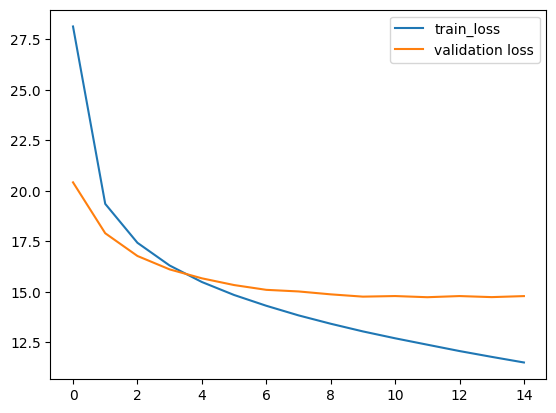

In [ ]:
# PLOT THE TRAINING HISTORY

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()


In [ ]:
# CHECK SAMPLE PREDICTIONS

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption(img_path=None):
    # Use a provided image or select a random image from the validation dataset
    sample_img = img_path if img_path else np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()


In [ ]:
# SAVING THE MODEL WEIGHTS

caption_model.save_weights("cnn_tr_fl_60-20-20.h5")


CALCULATING THE BLEU SCORE

In [ ]:
# DATA PREPARATION FOR BLEU


test_images = list(test_data.keys())
test_captions = list(test_data.values())


def get_candidates():
    cand = []
    for img in test_images:
        # Read the image from the disk
        img = decode_and_resize(img)

        # Pass the image to the CNN
        img = tf.expand_dims(img, 0)
        img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        encoded_img = caption_model.encoder(img, training=False)

        # Generate the caption using the Transformer decoder
        decoded_caption = "<start> "
        for i in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )
            sampled_token_index = np.argmax(predictions[0, i, :])
            sampled_token = index_lookup[sampled_token_index]
            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token

        decoded_caption = decoded_caption.replace("<start> ", "")
        decoded_caption = decoded_caption.replace(" <end>", "").strip()
        cand.append(decoded_caption.split())
    return cand


def get_references():
    refs = []
    for unit in test_captions:
        unit_refs = []
        for cap in unit:
            cap = cap.lower()
            cap = re.sub("[%s]" % re.escape(strip_chars), "", cap)
            cap = cap.split()[1:-1]
            unit_refs.append(cap)
        refs.append(unit_refs)
    return refs


candidates = get_candidates()
references = get_references()


In [ ]:
from nltk.translate.bleu_score import corpus_bleu


def compute_bleu_score(references, candidates):
    results = {}
    results["BLEU_1"] = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
    results["BLEU_2"] = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
    results["BLEU_3"] = corpus_bleu(
        references, candidates, weights=(0.33, 0.33, 0.33, 0)
    )
    results["BLEU_4"] = corpus_bleu(
        references, candidates, weights=(0.25, 0.25, 0.25, 0.25)
    )
    return results


bleu_score = compute_bleu_score(references, candidates)
for bleu_type, score in bleu_score.items():
    print(bleu_type, score)


BLEU_1 0.6048215403882279
BLEU_2 0.4246210978645567
BLEU_3 0.2920748847676351
BLEU_4 0.19256133546644863
